In [1]:
#imports & urls
import requests
import pandas as pd
from bs4 import BeautifulSoup
# ESPN
url = 'http://www.espn.com/nba/statistics/rpm/_/year/201'
def scrape_url_espn(url):
    data=[]
    r = requests.get(url)
    html_doc = r.text
    soup = BeautifulSoup(html_doc)
    soup.findAll('div',attrs={"class":"mod-content"})
    rows = soup.find('table').findAll('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
    dict_list = []
    for i in range(len(data)-1):
        dict1 = {}
        for j in range(9):
            dict1[data[0][j]] = data[i+1][j]
        dict_list.append(dict1)
    return dict_list
pre_frame = []
for yr in range(4,9,1):
    url_yr = url + str(yr)
    for page in range(1,20):
        try:
            url_yr_page = url_yr + '/page/' + str(page)
            df = pd.DataFrame(scrape_url_espn(url_yr_page))
            df['Year'] = '201' + str(yr)
        except:
            pass
        pre_frame.append(df)
new_df_list=[]
for df in pre_frame:
    if len(df.columns)>1:
        new_df_list.append(df)
player_rpm_per_yr = pd.concat(new_df_list)#,keys=["Year","RK"])
#player_rpm_per_yr.to_csv('espn_rpm_scraped.csv')
player_rpm_per_yr[['NAME','Pos']] = player_rpm_per_yr['NAME'].str.split(', ', expand=True)

In [2]:
# Basketball Reference
basketball_reference_players = []
for year in range(2014,2019):
    basketball_reference_players.append('https://www.basketball-reference.com/leagues/NBA_'+str(year)+'_totals.html')
def scrape_url_bbr_players(url):
    data=[]
    r = requests.get(url)
    html_doc = r.text
    soup = BeautifulSoup(html_doc)
    soup = soup.find('table')
    headr = soup.find('thead').findAll('tr')
    head = []
    for row in headr:
        col_h = row.findAll('th',attrs={"scope":"col"})
        col_h = [ele.text.strip() for ele in col_h]
        head.append([ele for ele in col_h])
    data.append(head[0][1:])
    rows = soup.find('tbody').findAll('tr',attrs={"class":['|',"full_table","italic_text partial_table"]})
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols])
    dict_list = []
    for i in range(1,len(data)):
        dict1 = {}
        for j in range(len(data[0])):
            dict1[data[0][j]] = data[i][j]
        dict_list.append(dict1)
    return dict_list
dfl=[]
for i in range(len(basketball_reference_players)):
    dl = scrape_url_bbr_players(basketball_reference_players[i])
    df = pd.DataFrame(dl)
    df['Year'] = str(2014 + i)
    dfl.append(df)
player_stats_per_yr = pd.concat(dfl)

In [3]:
# Combining player stats seperated by the different teams they played for in one year into one observation
nontot_pspy = player_stats_per_yr[:][player_stats_per_yr['Tm'] != 'TOT'] #non 'TOT'
tot_pspy = player_stats_per_yr[:][player_stats_per_yr['Tm'] == 'TOT'] #'TOT'
nontot_pspy.G = nontot_pspy.G.astype(float)
nontot_pspy = nontot_pspy.sort_values(['Year','Player','G'],ascending=[1,1,0])
nontot_pspy = nontot_pspy.drop_duplicates(subset=['Player','Year'],keep='first')
m_pspy = pd.merge(nontot_pspy,tot_pspy[['Year','Player','G']],how='left',on=['Year','Player'])
m_pspy.G_y = m_pspy.G_y.astype(float)
for y in range(len(m_pspy.G_y)):
    if m_pspy.G_y[y] > 0.01:
        m_pspy.G_x[y] = m_pspy.G_y[y]
m_pspy['G'] = m_pspy.G_x
m_pspy = m_pspy.drop(columns=['G_x','G_y'])

C:\ProgramData\Anaconda3.0\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [4]:
# Changing the names of players from one dataframe that differ from the other
def player_name_swap(player_name):
    dict_names = {'A.J. Hammons': 'AJ Hammons','C.J. Miles': 'CJ Miles','C.J. Wilcox': 'CJ Wilcox',
 'D.J. Stephens': 'DJ Stephens','Danuel House': 'Danuel House Jr.','Dennis Smith': 'Dennis Smith Jr.',
 'Derrick Jones': 'Derrick Jones Jr.','Derrick Walton': 'Derrick Walton Jr.','Erik Murphy': 'Erik Jay Murphy',
 'Frank Mason': 'Frank Mason III','Glen Rice': 'Glen Rice Jr.','Glenn Robinson': 'Glenn Robinson III',
 'J.J. Hickson': 'JJ Hickson','J.J. Redick': 'JJ Redick','J.R. Smith': 'JR Smith','James Ennis': 'James Ennis III',
 "Johnny O'Bryant": "Johnny O'Bryant III",'K.J. McDaniels': 'KJ McDaniels','Kelly Oubre': 'Kelly Oubre Jr.',
 'Larry Nance': 'Larry Nance Jr.','Maxi Kleber': 'Maximilian Kleber','Otto Porter': 'Otto Porter Jr.','P.J. Tucker': 'PJ Tucker',
 'Ray Allen*': 'Ray Allen','Steve Nash*': 'Steve Nash','Taurean Waller-Prince': 'Taurean Prince',
 'Tim Hardaway': 'Tim Hardaway Jr.','Wade Baldwin': 'Wade Baldwin IV','Walt Lemon, Jr.': 'Walt Lemon Jr.'}
    if player_name in dict_names.keys():
        player_name = player_name.replace(player_name,dict_names[player_name])
    return player_name
m_pspy.Player = m_pspy.Player.apply(player_name_swap)

In [5]:
# Merging dataframes
prpy = player_rpm_per_yr.rename(index=str, columns={"NAME": "Player"})
nba_stats_rpm = pd.merge(m_pspy,prpy,how='inner',on=['Year','Player'])
nba_stats_rpm['Pos'] = nba_stats_rpm.Pos_x
nba_stats_rpm.drop(['Pos_x','Pos_y'],axis=1,inplace=True)
nba_stats_rpm = nba_stats_rpm[['Year','Player','Pos','TEAM','Age','2P','2P%','2PA','3P','3P%','3PA',
                               'AST','BLK','DRB','ORB','FG','FG%','FGA','FT','FT%','FTA','GS','MP',
                               'PF','PTS','STL', 'TOV', 'TRB','eFG%','G','GP','MPG','RPM','DRPM','ORPM','WINS']]
nba_stats_rpm

,Year,Player,Pos,TEAM,Age,2P,2P%,2PA,3P,3P%,...,TOV,TRB,eFG%,G,GP,MPG,RPM,DRPM,ORPM,WINS
0,2014,A.J. Price,SG,MIN,27,13,.542,24,6,.273,...,7,10,.478,28.0,28,3.5,-0.09,-0.12,0.03,0.14
1,2014,Al Harrington,PF,WSH,33,48,.449,107,34,.340,...,34,80,.478,34.0,34,15.0,-0.64,0.13,-0.77,0.53
2,2014,Al Horford,C,ATL,27,234,.572,409,4,.364,...,64,244,.571,29.0,29,33.0,1.50,2.19,-0.69,2.29
3,2014,Al Jefferson,C,CHA,29,697,.512,1361,3,.200,...,124,792,.510,73.0,73,35.0,2.14,1.02,1.12,6.84
4,2014,Al-Farouq Aminu,SF,NO,23,221,.496,446,13,.271,...,88,496,.487,80.0,80,25.6,1.06,2.07,-1.01,4.25
5,2014,Alan Anderson,SF,BKN,31,110,.464,237,84,.339,...,62,175,.487,78.0,78,22.7,-2.38,-1.22,-1.16,-0.03
6,2014,Alec Burks,SG,UTAH,22,330,.480,688,50,.350,...,149,257,.487,78.0,78,28.1,-0.25,-1.68,1.43,2.82
7,2014,Alex Len,C,PHX,20,33,.423,78,0,,...,26,99,.423,42.0,42,8.6,-3.25,-0.23,-3.02,-0.21
8,2014,Alexey Shved,SG,MIN,25,46,.341,135,30,.294,...,48,81,.384,63.0,63,10.5,-0.70,-0.47,-0.23,0.68
9,2014,Alexis Ajinca,C,NO,25,136,.548,248,0,.000,...,63,277,.546,56.0,56,17.0,-1.97,0.92,-2.89,0.22


In [6]:
# Checking players that are in both dataframe but whose name differs and leaving out players only in one dataframe
bbr_names=set(m_pspy.Player.values)
espn_names=set(prpy.Player.values)
print(sorted(list(bbr_names-espn_names)))
print(sorted(list(espn_names-bbr_names)))

['Andrew White', 'Antawn Jamison', 'Arinze Onuaku', 'Bryce Dejean-Jones', 'Chris Smith', 'Chris Wright', 'Coty Clarke', 'Daniel Orton', 'Darius Johnson-Odom', 'Darius Morris', 'Dexter Pittman', 'Earl Clark', 'Elias Harris', 'Gary Payton', "Hamady N'Diaye", 'Henry Walker', 'Hilton Armstrong', "J.J. O'Brien", 'Jamaal Tinsley', 'James Webb', 'Josh Childress', 'Justin Harper', 'Keith Appling', 'Larry Drew', 'Lorenzo Brown', 'Maalik Wayns', 'Malcolm Lee', 'Manny Harris', 'Matt Williams', 'Mike Harris', 'R.J. Hunter', 'Reggie Williams', 'Roger Mason', 'Royal Ivey', 'Ryan Gomes', 'Sebastian Telfair', 'Shane Edwards', 'Solomon Jones', 'Stephen Jackson', 'Thanasis Antetokounmpo', 'Tyshawn Taylor', 'Vander Blue', 'Viacheslav Kravtsov', 'Vince Hunter', 'Walt Lemon', 'Will Cherry']
['Aaron Gray', 'Alex Stepheson', 'Andre Miller', 'Andrew Bynum', 'Antonius Cleveland', 'Austin Daye', 'Byron Mullens', 'Grant Jerrett', 'Jalen Jones', 'James Nunnally', 'Jan Vesely', 'Jarvis Varnado', 'Nando De Colo', '

In [7]:
# df to csv
nba_stats_rpm.to_csv('C:/Users/acer.DESKTOP-NM2UJ22/Springboard/Springboard/Capstone 1 - NBA player rating/nba_stats_cleaned.csv')

In [8]:
# imports and creating dataframe (df) from csv file for EDA
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LogisticRegression, ElasticNet
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore') #warnings.filterwarnings(action='once')
df = pd.read_csv('C:/Users/acer.DESKTOP-NM2UJ22/Springboard/Springboard/Capstone 1 - NBA player rating/nba_stats_cleaned.csv')
df = df[['Year','Player','Pos','TEAM','Age','2P','2P%','2PA','3P','3P%','3PA',
         'AST','BLK','DRB','ORB','FG','FG%','FGA','FT','FT%','FTA','GS','MP',
         'PF','PTS','STL', 'TOV', 'TRB','eFG%','G','GP','MPG','RPM','DRPM','ORPM','WINS']]
df=df[df['MP']>10]
df=df.drop(index=[300,897])
df[['2P%','3P%','FG%','FT%','eFG%']] = df[['2P%','3P%','FG%','FT%','eFG%']].fillna(0) * 100
# taking all season-long numerical variables and averaging them over 36 minutes per game
# also scaling the percentage variables from a proportion size to a percentage size
df_per_36mpg = df[['Year','Player','Pos','TEAM','Age','2P','2P%','2PA','3P','3P%','3PA','AST','BLK','DRB','ORB','FG','FG%','FGA','FT','FT%','FTA','GS','MP','PF','PTS','STL','TOV','TRB','eFG%','MPG','RPM']]
for col in ['2P','2PA','3P','3PA','AST','BLK','DRB','ORB','FG','FGA','FT','FTA','PF','PTS','STL','TOV','TRB']:
    df_per_36mpg[col]=round(df[col]*36*df['G']/df['MP'],2)

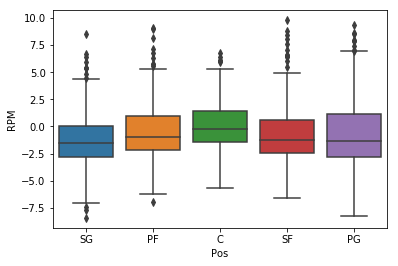

In [9]:
# EDA: boxplots per position
df.RPM=df.RPM.apply(lambda x: float(x))
sns.boxplot(x='Pos',y='RPM',data=df)

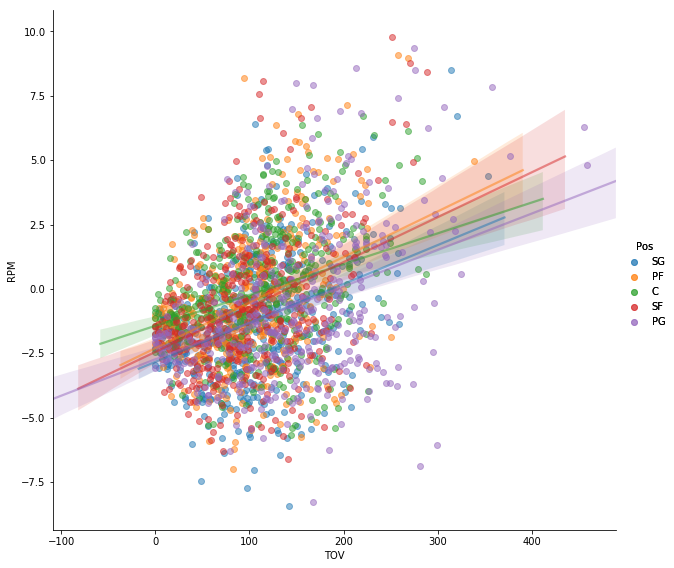

In [10]:
# EDA: pairplot - TurnOVers versus RealPlusMinus
g = sns.pairplot(df_per_36mpg[['Pos','TOV','RPM']],x_vars=["TOV"],y_vars=["RPM"],hue='Pos',
             kind='reg',plot_kws={'line_kws':{'alpha': 0.5}, 'scatter_kws': {'alpha': 0.5}},height=8)
g.add_legend()

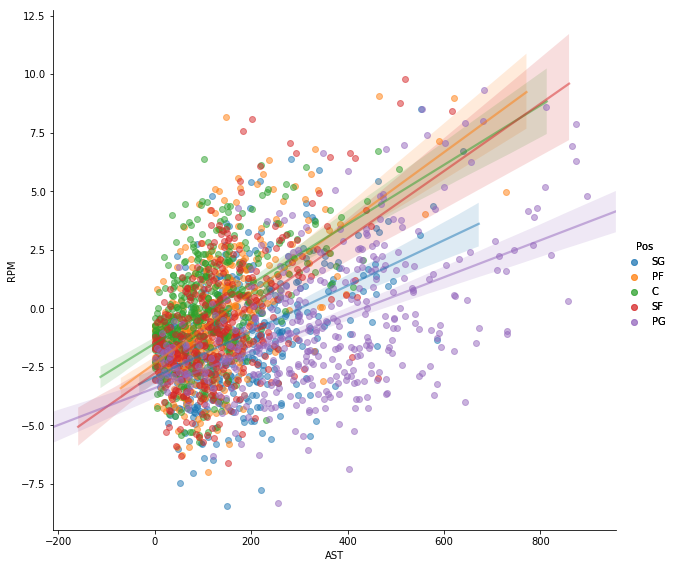

In [11]:
# EDA: pairplot - ASsiTs versus RealPlusMinus (others as well, not included in code)
g = sns.pairplot(df_per_36mpg[['Pos','AST','RPM']],x_vars=["AST"],y_vars=["RPM"],hue='Pos',
             kind='reg',plot_kws={'line_kws':{'alpha': 0.5}, 'scatter_kws': {'alpha': 0.5}},height=8)
g.add_legend()

In [12]:
# scoring each variable/feature with RPM per position (and all together/general) with r-squared using linear regression
df1=df_per_36mpg
positions=['C','PF','SF','PG','SG']
cols=df1.columns[4:-1]
a={'Position':[ele for ele in cols]}
for pos in positions:
    b=[]
    for col in cols:
        x=df1[df1.Pos==pos][col].apply(lambda x: np.nan_to_num(x))
        y=df1[df1.Pos==pos]['RPM']
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        if (p_value<0.01):
            b.append(round(r_value**2,4))
        else:
            b.append(0) #cutoff of p-value >= 0.01
    a[str(pos)]=b
b=[]    
for col in cols:
    x=df1[col].apply(lambda x: np.nan_to_num(x))
    y=df1['RPM']
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    if (p_value<0.01):
        b.append(round(r_value**2,4))
    else:
        b.append(0) #cutoff of p-value >= 0.01
a[str('General')]=b
df_plot=pd.DataFrame.from_dict(a,orient='index')
df_plot.columns=df_plot.iloc[0]
df_plot=df_plot[1:]
df_var_r_sq_by_pos=df_plot.T
df_var_r_sq_by_pos.sort_values(by=['General'],ascending=False) # r-squared against RPM

,C,PF,SF,PG,SG,General
Position,,,,,,
GS,0.2175,0.2719,0.2836,0.3688,0.2672,0.2758
MPG,0.2475,0.3113,0.2949,0.3597,0.2659,0.2631
MP,0.2292,0.3105,0.2569,0.3197,0.2534,0.2537
FT,0.1776,0.2378,0.2159,0.3311,0.1666,0.2263
FTA,0.1709,0.1993,0.2021,0.3041,0.1649,0.2163
PTS,0.1569,0.2307,0.2166,0.3226,0.1934,0.2148
STL,0.1882,0.2022,0.2507,0.2781,0.2454,0.1957
FG,0.1296,0.1998,0.1948,0.2682,0.1775,0.1916
DRB,0.1728,0.1481,0.214,0.2291,0.1222,0.1628


In [13]:
# first of many OLS regression charts
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod = smf.ols(formula='RPM ~ GS + MP + MPG + FT + FTA + PTS + FG + STL + DRB + FGA + AST + TOV + BLK', data=df_per_36mpg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    RPM   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     216.2
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        06:11:54   Log-Likelihood:                -4045.6
No. Observations:                2078   AIC:                             8119.
Df Residuals:                    2064   BIC:                             8198.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5018      0.148    -23.650      0.0

In [14]:
# considering variance inflation factors to understand variable effects on target (RPM)
df_vif=df_per_36mpg[['RPM','GS','MP','MPG','FT','FTA','PTS','FG','STL','DRB','2P','TRB','FGA','AST','2PA','TOV','BLK','eFG%','FG%','2P%','ORB','3P']]
df_vif=df_vif.rename(index=str,columns={'2P':'twP','2PA':'twPA','eFG%':'eFG_perc','FG%':'FG_perc','2P%':'twP_perc','3P':'thP'})
# more imports
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# creating a model based on significant variables/features
y, X = dmatrices('RPM ~ GS + MP + MPG + FT + FTA + PTS + FG + STL + DRB + twP + TRB + FGA + AST + twPA + TOV + BLK + eFG_perc + FG_perc + twP_perc + ORB + thP', df_vif, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor (ALL)"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
y_m, X_m = dmatrices('RPM ~ GS + MPG + FT + PTS + STL + DRB + AST + TOV + BLK + eFG_perc', df_vif, return_type='dataframe')
vif_m = pd.DataFrame()
vif_m["VIF Factor (MIN)"] = [variance_inflation_factor(X_m.values, i) for i in range(X_m.shape[1])]
vif_m["features"] = X_m.columns
vif = pd.merge(vif,vif_m,how='left')
vif.round(1)
# remove high VIF variables that are likely correlated to other variables (ex. Defensive Rebounds and Total Rebounds, etc.)
# repeat until similar factors of lesser r-squared value have been removed and VIF overall is substantially lower

,VIF Factor (ALL),features,VIF Factor (MIN)
0,9.180000e+01,Intercept,51.0
1,4.100000e+00,GS,3.2
2,1.590000e+01,MP,NaN
3,6.200000e+00,MPG,3.8
4,2.134742e+08,FT,4.1
5,3.330000e+01,FTA,NaN
6,4.117121e+09,PTS,6.7
7,3.017230e+09,FG,NaN
8,2.400000e+00,STL,2.1
9,1.210823e+09,DRB,3.2


In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod = smf.ols(formula='RPM ~ GS + MPG + FT + PTS + STL + DRB + AST + TOV + BLK + eFG_perc', data=df_vif)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    RPM   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     195.9
Date:                Wed, 13 Mar 2019   Prob (F-statistic):          1.54e-290
Time:                        06:11:54   Log-Likelihood:                -4245.7
No. Observations:                2078   AIC:                             8513.
Df Residuals:                    2067   BIC:                             8575.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0808      0.293    -20.742      0.0

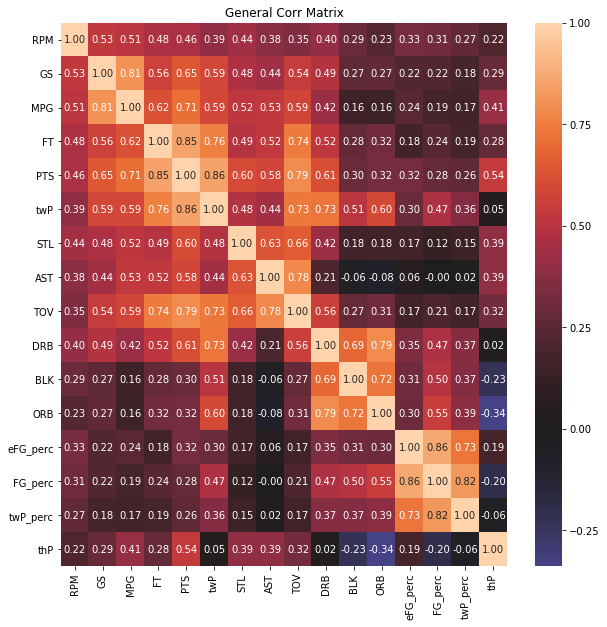

In [16]:
def corr_heat(dataframe):
    plt.subplots(figsize=(10,10))
    plt.title("General Corr Matrix")
    sns.heatmap(dataframe[['RPM', 'GS', 'MPG', 'FT', 'PTS', 'twP', 'STL', 'AST', 'TOV', 'DRB', 'BLK', 'ORB',
                           'eFG_perc', 'FG_perc', 'twP_perc', 'thP']].corr(), center=0, annot=True, fmt=".2f")
corr_heat(df_vif)

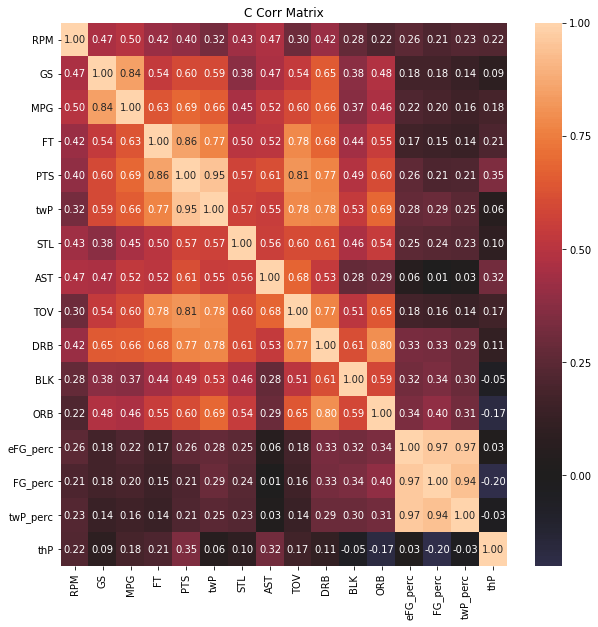

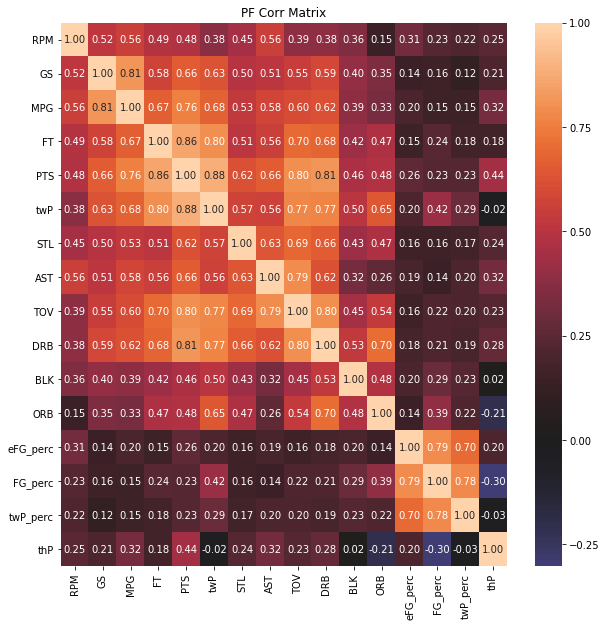

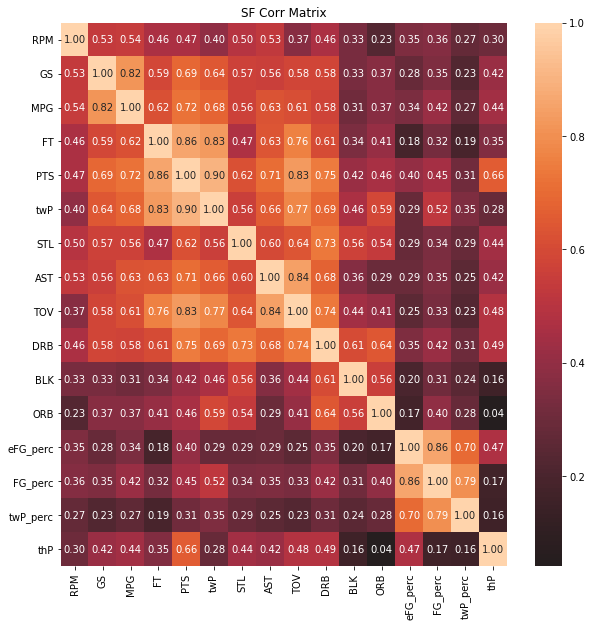

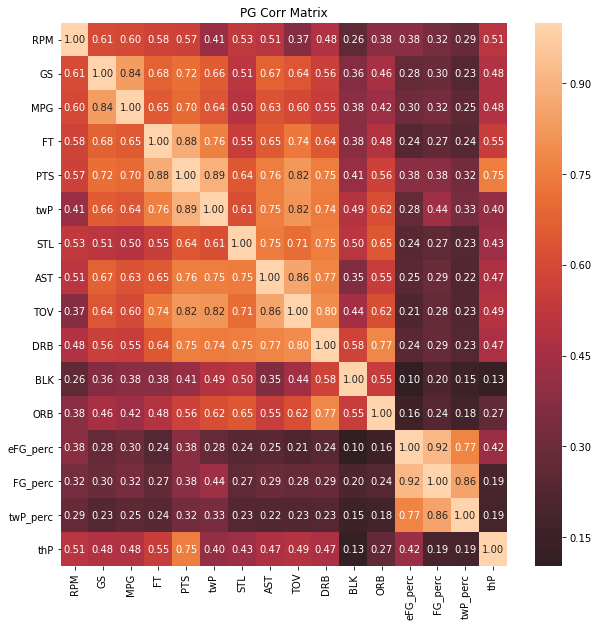

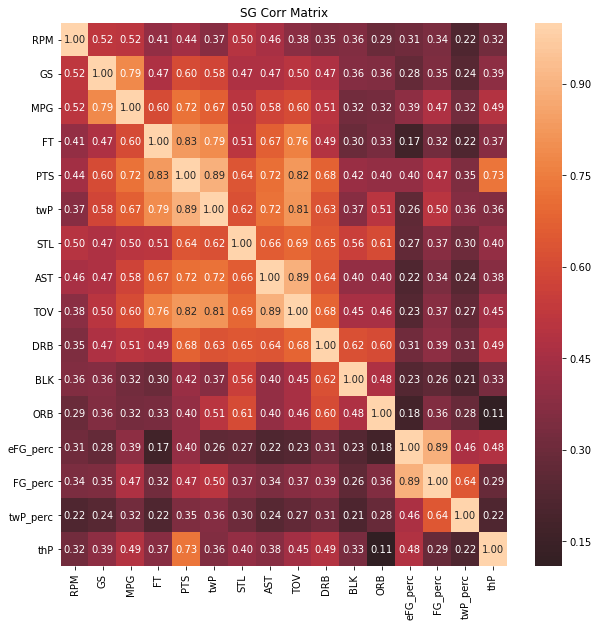

In [17]:
def corr_heat(dataframe):
    plt.subplots(figsize=(10,10))
    plt.title("{} Corr Matrix".format(position))
    sns.heatmap(dataframe[['RPM', 'GS', 'MPG', 'FT', 'PTS', 'twP', 'STL', 'AST', 'TOV', 'DRB', 'BLK', 'ORB',
                           'eFG_perc', 'FG_perc', 'twP_perc', 'thP']].corr(), center=0, annot=True, fmt=".2f")
for position in ['C','PF','SF','PG','SG']:
    df_p36_pos=df_per_36mpg[df_per_36mpg.Pos==position]
    df_p36_pos=df_p36_pos.rename(index=str,columns={'2P':'twP','2PA':'twPA','eFG%':'eFG_perc','FG%':'FG_perc','2P%':'twP_perc','3P':'thP','3P%':'thP_perc'})
    corr_heat(df_p36_pos)

In [18]:
# imports for regression models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
y, X = dmatrices('RPM ~ GS + MPG + FT + PTS + STL + DRB + AST + TOV + BLK + eFG_perc', df_vif, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
X_scaled_train = StandardScaler()
X_scaled_train = X_scaled_train.fit_transform(X_train)
# LinearRegression
reg = LinearRegression().fit(X_train,y_train)
cv_scores = cross_val_score(reg, X_train, y_train, cv=5)
print("LinearRegression",cv_scores,"\n\t\tAverage 5-Fold CV Score: {}".format(np.mean(cv_scores)))
# RidgeRegression
reg = RidgeCV().fit(X_scaled_train,y_train)
alpha = reg.alpha_
reg = Ridge(alpha).fit(X_scaled_train,y_train)
print("Ridge Regression",reg.score(X_scaled_train,y_train),'alpha:',alpha)

LinearRegression [0.4919037  0.53968145 0.47387408 0.50411545 0.45347469] 
		Average 5-Fold CV Score: 0.49260987465196726
Ridge Regression 0.5012702394413452 alpha: 1.0


LassoRegression Average 5-Fold CV Score: 0.4548384975381567
LassoReg coefficients
 [ 0.          0.58320105  0.13094527  0.57534303 -0.          0.40313449
  0.06262148  0.45111873 -0.60380942  0.32695874  0.41154729]


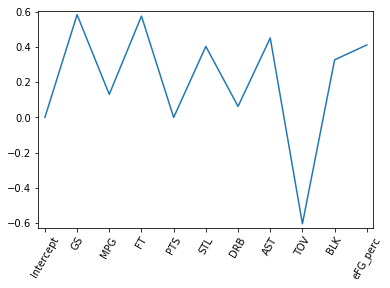

In [19]:
# Lasso
X_scaled_train = StandardScaler()
X_scaled_train = X_scaled_train.fit_transform(X_train)
lasso = Lasso(alpha=0.0025,normalize=True).fit(X_scaled_train,y_train)
cv_scores = cross_val_score(lasso, X_train, y_train, cv=5)
print("LassoRegression Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
lasso_coef = lasso.coef_
print("LassoReg coefficients\n",lasso_coef)
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.margins(0.02)
plt.show()

In [20]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5) # optimal depth
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)
# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
mse_1 = mean_squared_error(y_test, y_1)
mse_2 = mean_squared_error(y_test, y_2)
# Print the score
print("regr_1 r^2: {}".format(regr_1.score(X_test, y_test)))
print("regr_2 r^2: {}".format(regr_2.score(X_test, y_test)),'max depth of 5 is optimal')
print("regr_1 MSE: {}".format(mse_1))
print("regr_2 MSE: {}".format(mse_2))

regr_1 r^2: 0.3254065612412188
regr_2 r^2: 0.3575627814315234 max depth of 5 is optimal
regr_1 MSE: 4.551648527693651
regr_2 MSE: 4.334682568827084


In [21]:
# ElasticNet (linear combination of ridge and lasso)
warnings.filterwarnings('ignore') #warnings.filterwarnings(action='once')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)
# Create the hyperparameter grid + fit
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}
elastic_net = ElasticNet()
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)
gm_cv.fit(X_train,y_train)
# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_)) # l1 ratio = 0 (all ridge)
print("Tuned ElasticNet R squared: {}".format(r2)) # 0 < l1 ratio < 1, (some linear combination of ridge and lasso)
print("Tuned ElasticNet MSE: {}".format(mse)) # l1 ratio = 1 (all lasso)

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.45303615623574633
Tuned ElasticNet MSE: 3.7477360621667297


In [22]:
# breakdown of all appropriate techniques
from IPython.display import HTML, display
table = [['Model','$r^2$ score','description'],
         ['Linear Regression',0.474,'5 CVs'],
         ['Ridge Regression (L1)',0.489,'(WINNER) ... best alpha: 1.0'],
         ['Lasso Regression (L2)',0.431,'alpha=0.0025: scaled coef "GS" 0.62, "TOV" -0.53, "PTS" 0 (insig.)'],
         ['Decision Tree (max_depth=2)',0.335,'MSE: 4.579'],
         ['Decision Tree (max_depth=5)',0.388,'MSE: 4.216'], # optimal depth
         ['Elastic Net',0.446,'L1_ratio: 0.0, MSE: 3.7'],]
display(HTML('<table><tr>{}</tr></table>'.format('</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table))))

Model,$r^2$ score,description
Linear Regression,0.474,5 CVs
Ridge Regression (L1),0.489,(WINNER) ... best alpha: 1.0
Lasso Regression (L2),0.431,"alpha=0.0025: scaled coef ""GS"" 0.62, ""TOV"" -0.53, ""PTS"" 0 (insig.)"
Decision Tree (max_depth=2),0.335,MSE: 4.579
Decision Tree (max_depth=5),0.388,MSE: 4.216
Elastic Net,0.446,"L1_ratio: 0.0, MSE: 3.7"


In [23]:
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('linreg', LinearRegression())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
reg_scaled = pipeline.fit(X_train,y_train)
reg_unscaled = LinearRegression().fit(X_train, y_train)
# Compute and print metrics
print('Accuracy with Scaling: {}'.format(reg_scaled.score(X_train,y_train)))
print('Accuracy without Scaling: {}'.format(reg_unscaled.score(X_train,y_train)))

Accuracy with Scaling: 0.50127381920293
Accuracy without Scaling: 0.50127381920293


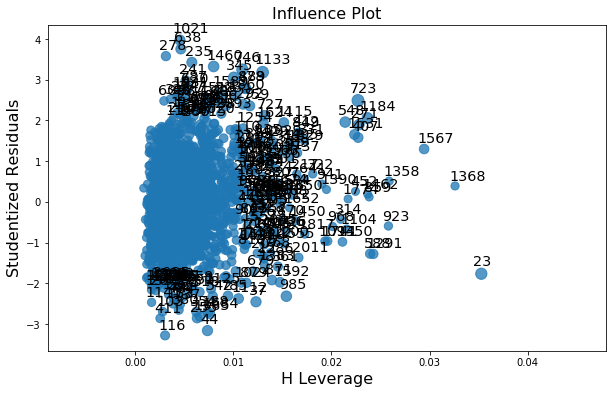

In [24]:
# remove unnessecary observations with very high influence or residuals
from statsmodels.graphics.regressionplots import *
mod_inf = smf.ols(formula='RPM ~ GS + MPG + FT + PTS + STL + DRB + AST + TOV + BLK + eFG_perc', data=df_vif).fit()
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(mod_inf, ax=ax, criterion="cooks", size=12)

In [25]:
# model split into groups with features having multi-collinearity for Partial Component Reduction
y, X_PCA1 = dmatrices('RPM ~ GS+MPG+FT+PTS+STL+twP+AST+TOV+thP', df_vif, return_type='dataframe')
X_PCA1 = X_PCA1.drop(labels='Intercept', axis=1)
y, X_PCA2 = dmatrices('RPM ~ DRB+BLK+ORB', df_vif, return_type='dataframe')
X_PCA2 = X_PCA2.drop(labels='Intercept', axis=1)
y, X_PCA3 = dmatrices('RPM ~ eFG_perc+FG_perc+twP_perc', df_vif, return_type='dataframe')
X_PCA3 = X_PCA3.drop(labels='Intercept', axis=1)
pca = PCA()
X_reduced_PCA_1 = pd.DataFrame(pca.set_params(n_components=8).fit_transform(scale(X_PCA1)))
X_reduced_PCA_2 = pd.DataFrame(pca.set_params(n_components=3).fit_transform(scale(X_PCA2)))
X_reduced_PCA_3 = pd.DataFrame(pca.set_params(n_components=3).fit_transform(scale(X_PCA3)))
X_reduced_PCA = pd.concat([X_reduced_PCA_1,X_reduced_PCA_2,X_reduced_PCA_3],axis=1)
X_reduced_PCA.columns=['PC_'+str(i) for i in range(1,15)]
y=y.reset_index()
df_PCA=pd.merge(y,X_reduced_PCA,left_index=True,right_index=True).set_index('index')
# reduced model into non-redundant partial features
y_PCA, X_PCA = dmatrices('RPM~PC_1+PC_2+PC_3+PC_4+PC_5+PC_6+PC_8+PC_9+PC_11+PC_12', data=df_PCA, return_type='dataframe')
X_PCA = X_PCA.drop(labels='Intercept', axis=1)
# split dataset for final prediction column
X_PCA_1, X_PCA_2, y_PCA_1, y_PCA_2 = train_test_split(X_PCA,y_PCA,test_size=0.5,random_state=101)
# using best regressor
reg1 = RidgeCV().fit(X_PCA_1,y_PCA_1)
reg2 = RidgeCV().fit(X_PCA_2,y_PCA_2)
# create variable for predicting RPM (new player ranking metric)
pRPM1=pd.DataFrame(reg2.predict(X_PCA_1).round(2),index=X_PCA_1.index)
pRPM2=pd.DataFrame(reg1.predict(X_PCA_2).round(2),index=X_PCA_2.index)
pRPM=pRPM1.append(pRPM2).sort_index()
df_PCA['predRPM']=pRPM
# create variable for difference of RPM & predicted RPM (new player ranking metric)
df_PCA['predRPM_resid']=df_PCA['RPM']-df_PCA['predRPM']
df_PCA.index=df_PCA.index.astype('int64')
df_RPM=pd.merge(df_per_36mpg[['Year','Player','Pos','TEAM','Age']],df_PCA[['RPM','predRPM','predRPM_resid']],left_index=True,right_index=True)

In [26]:
# partial component reduction process testing
def Part_Comp_Red(model_1='',model_2='',model_3=0,n_comp=[],position='C'):
    pca = PCA()
    dataframe=df_per_36mpg[df_per_36mpg.Pos==position]
    dataframe=dataframe.rename(index=str,columns={'2P':'twP','2PA':'twPA','eFG%':'eFG_perc','FG%':'FG_perc','2P%':'twP_perc','3P':'thP','3P%':'thP_perc'})
    y, X_PCA1 = dmatrices(model_1, dataframe, return_type='dataframe')
    X_PCA1 = X_PCA1.drop(labels='Intercept', axis=1)
    y, X_PCA2 = dmatrices(model_2, dataframe, return_type='dataframe')
    X_PCA2 = X_PCA2.drop(labels='Intercept', axis=1)
    X_reduced_PCA_1 = pd.DataFrame(pca.set_params(n_components=n_comp[0]).fit_transform(scale(X_PCA1)))
    X_reduced_PCA_2 = pd.DataFrame(pca.set_params(n_components=n_comp[1]).fit_transform(scale(X_PCA2)))
    if (model_3==0):
        X_reduced_PCA = pd.concat([X_reduced_PCA_1,X_reduced_PCA_2],axis=1)
    else:
        y, X_PCA3 = dmatrices(model_3, dataframe, return_type='dataframe')
        X_PCA3 = X_PCA3.drop(labels='Intercept', axis=1)
        X_reduced_PCA_3 = pd.DataFrame(pca.set_params(n_components=n_comp[2]).fit_transform(scale(X_PCA3)))
        X_reduced_PCA = pd.concat([X_reduced_PCA_1,X_reduced_PCA_2,X_reduced_PCA_3],axis=1)
    X_reduced_PCA.columns=['PC_'+str(i) for i in range(1,len(X_reduced_PCA.columns)+1)]
    y=y.reset_index(drop=True)
    df_PCA_=pd.merge(y,X_reduced_PCA,left_index=True,right_index=True)
    return df_PCA_
df_PCA_C=Part_Comp_Red('RPM~GS+MPG+FT+PTS+STL+twP+AST+TOV+DRB+BLK+ORB','RPM~eFG_perc+FG_perc+twP_perc','RPM~thP+thP_perc',[10,2,2],'C')
df_PCA_PF=Part_Comp_Red('RPM~GS+MPG+FT+PTS+STL+twP+AST+TOV+DRB+BLK+ORB','RPM~eFG_perc+FG_perc+twP_perc','RPM~thP+thP_perc',[10,3,2],'PF')
df_PCA_SF=Part_Comp_Red('RPM~GS+MPG+FT+PTS+STL+twP+AST+TOV+DRB+BLK+ORB','RPM~eFG_perc+FG_perc+twP_perc','RPM~thP+thP_perc',[10,3,2],'SF')
df_PCA_PG=Part_Comp_Red('RPM~GS+MPG+FT+PTS+STL+twP+AST+TOV+DRB+BLK+ORB+thP','RPM~eFG_perc+FG_perc+twP_perc','RPM~thP_perc',[10,3,1],'PG')
df_PCA_SG=Part_Comp_Red('RPM~GS+MPG+FT+PTS+STL+twP+AST+TOV+DRB+BLK+ORB+thP','RPM~eFG_perc+FG_perc+twP_perc+thP_perc',0,[10,4],'SG')

In [27]:
# scoring each position's model on itself
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import train_test_split
# PCA model
y_PCA, X_PCA = dmatrices('RPM~PC_1+PC_2+PC_3+PC_4+PC_5+PC_6+PC_8+PC_9+PC_11+PC_12', data=df_PCA, return_type='dataframe')
X_PCA = X_PCA.drop(labels='Intercept', axis=1)
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,test_size=0.2,random_state=69)
# RidgeCV
reg = RidgeCV().fit(X_train_PCA,y_train_PCA)
alpha = reg.alpha_
print("Ridge Regession score of each Model")
print('Gen Model:',reg.score(X_test_PCA,y_test_PCA).round(4),'\talpha:',alpha)
pca_dict={'C':['RPM~PC_1+PC_2+PC_4+PC_6+PC_7+PC_8+PC_9+PC_11',df_PCA_C],'PF':['RPM~PC_1+PC_2+PC_4+PC_8+PC_9+PC_10+PC_11',df_PCA_PF],
          'SF':['RPM~PC_1+PC_2+PC_3+PC_4+PC_9+PC_10+PC_11',df_PCA_SF],'PG':['RPM~PC_1+PC_2+PC_3+PC_4+PC_5+PC_7+PC_8+PC_10+PC_11',df_PCA_PG],
          'SG':['RPM~PC_1+PC_3+PC_4+PC_5+PC_6+PC_7+PC_9+PC_10+PC_11',df_PCA_SG]}
for mod_df_ in pca_dict:
    y_, X_ = dmatrices(pca_dict[mod_df_][0], data=pca_dict[mod_df_][1], return_type='dataframe')
    X_ = X_.drop(labels='Intercept', axis=1)
    reg = RidgeCV().fit(X_,y_)
    alpha = reg.alpha_
    print(mod_df_,'Model: ',reg.score(X_,y_).round(4),'\talpha:',alpha)

Ridge Regession score of each Model
Gen Model: 0.447 	alpha: 1.0
C Model:  0.4564 	alpha: 1.0
PF Model:  0.5252 	alpha: 1.0
SF Model:  0.5472 	alpha: 1.0
PG Model:  0.5978 	alpha: 1.0
SG Model:  0.4159 	alpha: 10.0


In [28]:
# scoring the gereral model on each position
pos=df[['Pos']].reset_index(drop=True)
df_PCA_pos=pd.merge(pos,df_PCA,left_index=True,right_index=True)
#df_PCA_pos.groupby("Pos")
print("General Ridge Regression Model scored for each position")
for position in ['C','PF','SF','PG','SG']:
    df_pos=df_PCA_pos[df_PCA_pos.Pos==position]
    y_PCA_pos, X_PCA_pos = dmatrices('RPM~PC_1+PC_2+PC_3+PC_4+PC_5+PC_6+PC_8+PC_9+PC_11+PC_12', data=df_pos, return_type='dataframe')
    X_PCA_pos = X_PCA_pos.drop(labels='Intercept', axis=1)
    reg = RidgeCV().fit(X_PCA_pos,y_PCA_pos)
    alpha = reg.alpha_
    print("Pos: {}\t".format(position),'Score:',reg.score(X_PCA_pos,y_PCA_pos).round(4),' alpha =',alpha)
    #mod = smf.ols(formula='RPM ~ GS + MP + MPG + FT + FTA + PTS + FG + STL + DRB + twP + TRB + FGA + AST + twPA + TOV + BLK + eFG_perc + FG_perc + twP_perc + ORB + thP', data=df_pos)
    #res = mod.fit()    
    #print("Pos: {}\t".format(pos),"Score:",res.rsquared.round(4))

General Ridge Regression Model scored for each position
Pos: C	 Score: 0.4808  alpha = 1.0
Pos: PF	 Score: 0.4825  alpha = 1.0
Pos: SF	 Score: 0.4952  alpha = 1.0
Pos: PG	 Score: 0.5095  alpha = 1.0
Pos: SG	 Score: 0.5345  alpha = 1.0


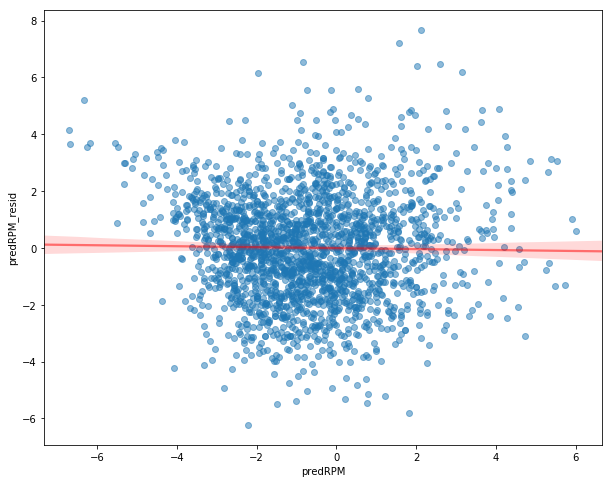

In [29]:
# plotting predicted RPM vs. residuals with regression line
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
ax = sns.regplot(x="predRPM",y="predRPM_resid",data=df_RPM,line_kws={'color':'red','alpha':0.5},scatter_kws={'alpha': 0.5})
plt.show()

In [30]:
# sorted by predRPM_resid, only showing data with actual and predicted RPM greater than zero
df_RPM[(df_RPM.predRPM>0)&(df_RPM.RPM>0)].sort_values('predRPM_resid',ascending=False)

,Year,Player,Pos,TEAM,Age,RPM,predRPM,predRPM_resid
1021,2016,LeBron James,SF,CLE,31,9.79,2.11,7.68
638,2015,LeBron James,SF,CLE,30,8.78,1.57,7.21
235,2014,LeBron James,PF,MIA,29,9.08,2.61,6.47
1460,2017,LeBron James,SF,CLE,32,8.42,2.03,6.39
746,2015,Stephen Curry,PG,GS,26,9.34,3.16,6.18
478,2015,DeMarcus Cousins,C,SAC,24,6.12,0.54,5.58
620,2015,Khris Middleton,SF,MIL,23,6.06,0.78,5.28
889,2016,Draymond Green,PF,GS,25,8.97,4.08,4.89
1133,2016,Stephen Curry,PG,GS,27,8.51,3.64,4.87
1518,2017,Nikola Jokic,C,DEN,21,6.73,1.88,4.85


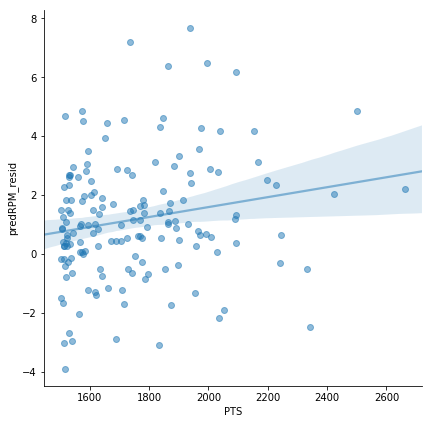

In [31]:
# plot of player's points (PTS) vs. predicted RPM residuals (predRPM_resid) ~ showing PTS greater than 1500
df_RPM_analysis=pd.merge(df_per_36mpg[df_per_36mpg.PTS>1500],df_PCA[['RPM','predRPM','predRPM_resid']],left_index=True,right_index=True)
g = sns.pairplot(df_RPM_analysis[['Pos','predRPM_resid','PTS']],x_vars=["PTS"],y_vars=["predRPM_resid"],
             kind='reg',plot_kws={'line_kws':{'alpha': 0.5}, 'scatter_kws': {'alpha': 0.5}},height=6)
g.add_legend()
# from plot we see high scorers tend to be "undervalued" with predRPM_resid > 0 ... (RPM > predRPM)